In [2]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... one
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 44.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 72.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 59.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 81.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 59.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 81.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 77.1 MB/s eta 0:00:0000:0100:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import zipfile
import random
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

from src.features.functions_preprocessing import *
from src.models.rnn_encoder_decoder import *
from src.models.transformer import *

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


# **Kaggle dataset**

In [5]:
!kaggle datasets download -d sbhatti/news-summarization

Dataset URL: https://www.kaggle.com/datasets/sbhatti/news-summarization
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 1.37G/1.37G [00:51<00:00, 35.8MB/s]
100%|██████████████████████████████████████| 1.37G/1.37G [00:51<00:00, 28.7MB/s]


In [6]:
with zipfile.ZipFile("news-summarization.zip", "r") as zip_ref:
    zip_ref.extractall("news-summarization")

In [3]:
news_data = pd.read_csv("news-summarization/data.csv")

In [4]:
news_data.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [5]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

(CNN) -- It was Rosy Esparza's first trip to Six Flags. She sat on the Texas Giant, a 14-story-high roller coaster that boasts what the amusement park calls "the world's steepest drop." Minutes later, one of the roller coaster's seats came back empty. Now Esparza is dead and Six Flags Over Texas representatives say the theme park is committed to finding out what led to the woman's death on Friday. Esparza's son-in-law and his wife were sitting in front of her at the time. Contrary to witness accounts reported by CNN affiliates, Ronald Segovia told CNN he did not hear his mother-in-law mention that her seat did not lock properly. Segovia also told CNN that Esparza was sitting by herself, contrary to initial reports that she was sitting beside her son. Her sons, according to Segovia, were not there. In Facebook posts on Saturday, her sons described the experience as a nightmare. A flood of condolences and prayers poured in. "Only God knows Mama," Amado Esparza posted in Spanish along wit

In [6]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [7]:
news_data = news_data[
    (lengths_article >= lengths_article.quantile(0.05))
    & (lengths_article <= lengths_article.quantile(0.95))
]

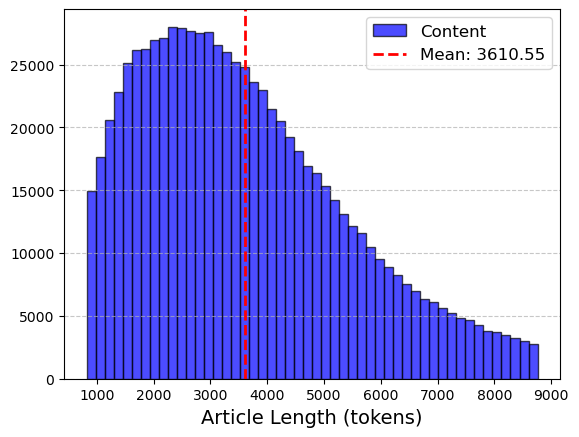

In [8]:
pd.DataFrame(news_data["Content"].str.len()).plot(
    kind="hist", bins=50, edgecolor="black", alpha=0.7, color="blue"
)
plt.axvline(
    news_data["Content"].str.len().mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {news_data["Content"].str.len().mean():.2f}',
)
plt.xlabel("Article Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [9]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    783457.000000
mean        288.041624
std         226.311050
min           1.000000
25%         154.000000
50%         244.000000
75%         328.000000
max        8541.000000
Name: Summary, dtype: float64

In [10]:
news_data = news_data[
    (lengths_summary >= lengths_summary.quantile(0.05))
    & (lengths_summary <= lengths_summary.quantile(0.95))
]

In [11]:
news_data["Summary"].str.len().describe()

count    705951.000000
mean        255.337233
std         104.177187
min         103.000000
25%         168.000000
50%         244.000000
75%         317.000000
max         597.000000
Name: Summary, dtype: float64

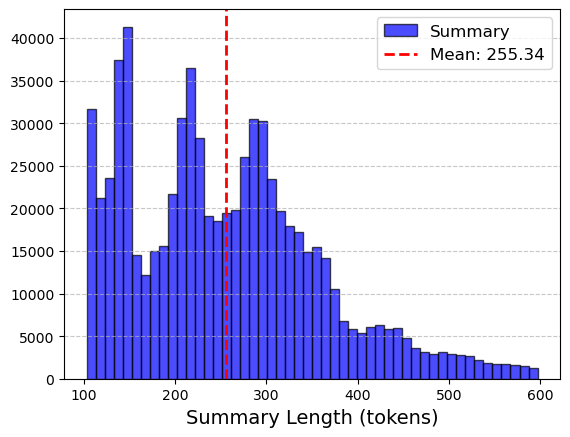

In [12]:
news_data["Summary"].str.len().plot(
    kind="hist", bins=50, edgecolor="black", alpha=0.7, color="blue"
)
plt.axvline(
    news_data["Summary"].str.len().mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {news_data["Summary"].str.len().mean():.2f}',
)
plt.xlabel("Summary Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [13]:
len(news_data)

705951

In [14]:
# news_data["Content"] = news_data["Content"].apply(preprocess_article)
# news_data["Summary"] = news_data["Summary"].apply(preprocess_summary)

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [16]:
train_data = news_data[:5000]
test_data = news_data[5000:6000]

In [17]:
tokenized_articles = tokenizer(
    list(train_data["Content"]),
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    max_length=587,
)["input_ids"]

tokenized_summaries = tokenizer(
    list(train_data["Summary"]),
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    max_length=587,
)["input_ids"]

tokenized_summaries = torch.cat(
    [torch.zeros(tokenized_summaries.size(0), 1), tokenized_summaries], dim=1
)
article_ids = tokenized_articles.long()
summary_ids = tokenized_summaries.long()

# **RNN**

# **Transformer**

In [23]:
batch_size = 10
max_seq_length=587
max_sum_length=587

dataset = TensorDataset(tokenized_articles, tokenized_summaries)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
model_transformer = Transformer(
    pad_idx=0,
    voc_size=tokenizer.vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=max_seq_length,
    dec_max_len=max_sum_length,
    ffn_hidden=128,
    n_layers=3,
)

In [25]:
num_epochs = 50
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=5e-4)
model = model_transformer.to(device)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):
        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch, summary_batch[:, :-1])
        summary_batch = summary_batch[:, 1:]
        # Compute loss
        loss = loss_fn(
            outputs.reshape(-1, outputs.shape[-1]), summary_batch.reshape(-1)
        )
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step % 1000 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

# **LLM Llama 3.2**

In [ ]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

hf_token = config["huggingface"]["token"]
login("hf_token")

In [ ]:
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")